In [ ]:
import os
import sys
from cProfile import label

from typing import Any

import  paddle
import numpy as np
import  matplotlib.pyplot as plt
from fontTools.misc.plistlib import end_dict
from pygments.lexer import words

from simple_nn_framework.simple_nn.example import accuracies, losses

print(paddle.__version__)

In [83]:
import  io
import os
import random
import  json
# 谣言数据集路径
rumor_class_dirs=os.listdir("./dataset/Chinese_Rumor_Dataset-master/CED_Dataset/rumor-repost/")
# 非谣言数据集路径
non_rumor_class_dirs=os.listdir("./dataset/Chinese_Rumor_Dataset-master/CED_Dataset/non-rumor-repost/")
# 原始微博数据集路径
original_microblog="./dataset/Chinese_Rumor_Dataset-master/CED_Dataset/original-microblog/"

# 谣言标签设置为0非谣言标签设置为1
rumor_label="0"
non_rumor_label="1"

#统计谣言数据与非谣言数据总数
rumor_num=0
non_rumor_num=0

all_rumor_list=[]
all_non_rumor_list=[]

# 解析谣言数据
for  rumor_class_dir in rumor_class_dirs:
    if rumor_class_dir.endswith(".json"):
        with open(original_microblog+rumor_class_dir, "r", encoding="utf-8") as f:
            rumor_content=f.read()
        rumor_dict=json.loads(rumor_content)
        all_rumor_list.append(rumor_label+"\t"+rumor_dict["text"]+"\n")
        rumor_num+=1
        
#解析非谣言数据
for  non_rumor_class_dir in non_rumor_class_dirs:
    if non_rumor_class_dir.endswith(".json"):
        with open(original_microblog+non_rumor_class_dir, "r", encoding="utf-8") as f2:
            non_rumor_content=f2.read()
        non_rumor_dict=json.loads(non_rumor_content)
        all_non_rumor_list.append(non_rumor_label+"\t"+non_rumor_dict["text"]+"\n")
        non_rumor_num+=1
            
print("谣言数据总数为：",str(rumor_num))
print("非谣言数据总数为：",str(non_rumor_num))
        

谣言数据总数为： 1538
非谣言数据总数为： 1849


In [85]:
#数据乱序写入all_data.txt文件
data_list_path="./dataset/Chinese_Rumor_Dataset-master/CED_Dataset/"
all_data_path=data_list_path+"all_data.txt"

all_data_list=all_rumor_list+all_non_rumor_list
random.seed(42)  # 设置种子

random.shuffle(all_data_list)

with open(all_data_path, "w", encoding="utf-8") as f3:
    f3.seek(0)
    f3.truncate() #清空文件 all_data_path 的所有内容

with open(all_data_path, "a", encoding="utf-8") as f33:
    for data in all_data_list:
        f33.write(data)


In [86]:
#生成数据字典
def create_dict(data_path,dict_path):
    # 创建目录（如果不存在）
  os.makedirs(os.path.dirname(dict_path), exist_ok=True)
  with open(dict_path , "w", encoding="utf-8") as f4:
      f4.seek(0)
      f4.truncate()
  dict_set=set()
 #读取全部数据
  with open(data_path, "r", encoding="utf-8") as f5:
   lines=f5.readlines()
   for line in lines:
       content=line.split("\t")[-1].replace('\n','')
       for s in content:
           dict_set.add(s)
   #把元组转换成字典，一个字对应一个数字
   dict_list=[]
   i=0
   for s in dict_set:
       dict_list.append([s,i])
       i+=1
    #添加未知字符
   dict_txt=dict(dict_list)
   end_dict={"<unk>":i}
   dict_txt.update(end_dict)
   end_dict={"<pad>":i+1}
   dict_txt.update(end_dict)
   
   #把字典写入文件
   with open(dict_path, "w", encoding="utf-8") as f6:
       f6.write(str(dict_txt))
       
   print("字典生成完毕！")

In [87]:
#创建序列化数据，划分训练集验证集
def create_data_list(data_list_path):
    
    # 清空验证集
    with open (os.path.join(data_list_path,"eval_list.txt"),'w',encoding="utf-8") as f7:
        f7.seek(0)
        f7.truncate()
    # 清空训练集
    with open (os.path.join(data_list_path,"train_list.txt"),'w',encoding="utf-8") as f8:
        f8.seek(0)
        f8.truncate()
    
    with open (os.path.join(data_list_path,"dict.txt"),'r',encoding="utf-8") as f9:
         dict_txt=eval(f9.readline())
    
    with open(os.path.join(data_list_path,"all_data.txt"),'r',encoding="utf-8") as f10:
        lines=f10.readlines()
 
    i=0
    maxlen=0
    with open (os.path.join(data_list_path,"train_list.txt"),'a',encoding="utf-8") as f11, open (os.path.join(data_list_path,"eval_list.txt"),'a',encoding="utf-8") as f12:
        for line in lines:
            words=line.split('\t')[-1].replace('\n','')
            maxlen=max(maxlen,len(words))
            label=line.split('\t')[0]
            labs=""
#            每八个抽取一个作为验证
            if i%8==0:
                for s in words :
                    lab=str(dict_txt[s])
                    labs=labs+lab+','
                labs=labs[:-1]
                labs=labs+'\t'+label+'\n'
                f12.write(labs)#验证
            else:
                for s in words :
                    lab=str(dict_txt[s])
                    labs=labs+lab+','
                labs=labs[:-1]
                labs=labs+'\t'+label+'\n'
                f11.write(labs)#训练
            i=i+1
            
    print("数据列表生成完毕")
    print(maxlen)

In [88]:
data_root_path = './dataset/Chinese_Rumor_Dataset-master/CED_Dataset/'
data_path=os.path.join(data_root_path,'all_data.txt')
dict_path=os.path.join(data_root_path,'dict.txt')
create_dict(data_path, dict_path)
create_data_list(data_root_path)



字典生成完毕！
数据列表生成完毕
226


In [89]:
def load_vocab(file_path):
    fr=open(file_path,'r',encoding='utf-8')
    vocab=eval(fr.read())
    fr.close()
    
    return vocab

In [90]:
#打印前2条训练数据
vocab=load_vocab('./dataset/Chinese_Rumor_Dataset-master/CED_Dataset/dict.txt')

def ids_to_str(ids):
    words=[]
    for id in ids:
        w=list(vocab.keys())[list(vocab.values()).index(int(id))]
        words.append(w if isinstance(w,str) else w.decode('ASCII'))
    return " ".join(words)
file_path='./dataset/Chinese_Rumor_Dataset-master/CED_Dataset/train_LIST.txt'
with io.open(file_path,'r',encoding='utf-8') as fin:
    i=0
    for line in fin:
        i=i+1
        cols=line.strip().split('\t')
        if len(cols)!=2:
            sys.stderr.write("ERROR")
            continue
        label=int(cols[1])
        wids=cols[0].split(',')
        print(str(i)+":")
        print("sentence list id is",wids)
        print("label is:",label)
        print("sentence list is:",ids_to_str(wids))
        print("-----------------------------------------")
        
        if i==2:break
        

1:
sentence list id is ['2625', '1636', '4169', '3725', '3650', '1691', '3637', '3507', '2096', '2892', '4290', '965']
label is: 0
sentence list is: 以 後 我 玩 微 博 還 有 什 麼 意 義
-----------------------------------------
2:
sentence list id is ['4013', '2394', '2999', '232', '4098', '2424', '1077', '3606', '2465', '1318', '3486', '3374', '2457', '3121', '3121', '3121', '3121', '3121', '3121', '3725', '2436', '4071', '266', '3205', '1759', '3181', '3795', '2417', '1896', '1961', '2531', '3693', '3040', '553', '395', '2877', '2718', '3809', '1242', '2070', '4393', '3727', '3471', '3683', '2114', '3795', '2417', '2463', '2877', '2718', '1978', '2957', '3727', '3471', '3980', '3507', '4296', '96', '553', '3651', '4338', '2227', '830', '3121', '2524', '1077', '913', '3795', '2417', '1237', '2577', '3795', '2417', '3374', '2382', '1642', '4296', '1498', '2329', '4340', '4340', '4340', '4340', '4340', '4340', '1047']
label is: 1
sentence list is: T M D 权 志 龙 不 能 这 么 死 蠢 啊 ! ! ! ! ! ! 玩 之 前 就 老 觉 得 

In [101]:
vocab=load_vocab(os.path.join(data_root_path,'dict.txt'))

class RumorDataset(paddle.io.Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.all_data = []

        with io.open(self.data_path, "r", encoding="utf-8") as fin:
            for line in fin:
                cols = line.strip().split("\t")
                if len(cols) != 2:
                    sys.stderr.write("invalid input format!\n")
                    continue
                label = []
                label.append(int(cols[1]))
                wids = cols[0].split(",")
                if len(wids) >= 150:
                    wids = np.array(wids[:150]).astype('int64')
                else:
                    wids = np.concatenate([wids,[vocab["<pad>"]]*(150-len(wids))]).astype('int64')
                label = np.array(label).astype('int64')
                self.all_data.append([wids, label])

    def __getitem__(self, item):
        data,label=self.all_data[item]
        return data,label
    
    def __len__(self):
        return len(self.all_data)
    
batch_size=32
train_dataset=RumorDataset(os.path.join(data_root_path,'train_list.txt'))
eval_dataset=RumorDataset(os.path.join(data_root_path,'eval_list.txt'))
train_loader=paddle.io.DataLoader(train_dataset,return_list=True,batch_size=batch_size,shuffle=True,drop_last=True)
eval_loader=paddle.io.DataLoader(eval_dataset,return_list=True,batch_size=batch_size,shuffle=True,drop_last=True)


#check

print("=====train dataset===========")
for data,label in train_dataset:
    print(data)
    print(np.array(data).shape)
    print(label)
    break
print("=====eval dataset===========")
for data,label in eval_dataset:
    print(data)
    print(np.array(data).shape)
    print(label)
    break

        
                    
                

=====train dataset===========
[2625 1636 4169 3725 3650 1691 3637 3507 2096 2892 4290  965 4410 4410
 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410
 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410
 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410
 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410
 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410
 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410
 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410
 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410
 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410
 4410 4410 4410 4410 4410 4410 4410 4410 4410 4410]
(150,)
[0]
=====eval dataset===========
[ 159  484 3825 4059 1874 2329 2652 4139 1896 1218 1042  611  810 1829
  189   23 2598 3154  233 2734 1237 2602 1160  611 1907   91 3507 1192
 3667 2038 3154 1895 1990 

In [114]:
import  paddle
from  paddle.nn import Conv2D,Linear,Embedding
from paddle import   to_tensor
from paddle.nn import functional as F

class LstmModel(paddle.nn.Layer):
   def __init__(self):
       super(LstmModel, self).__init__()
       self.dict_dim=vocab["<pad>"]
       self.emb_dim=128
       self.hid_dim=128
       self.class_dim=2
       self.embedding=Embedding(
           self.dict_dim+1,self.emb_dim,
           sparse=False)
       self.fc1=Linear(self.emb_dim,self.hid_dim)
       self.lstm=paddle.nn.LSTM(self.hid_dim,self.hid_dim)
       self.fc2=Linear(19200,self.class_dim)
       
   def forward(self, inputs):
        emb=self.embedding(inputs)
        fc_1=self.fc1(emb)
        x=self.lstm(fc_1)
        x=paddle.reshape(x[0],[0,-1])
        x=self.fc2(x) 
        x=paddle.nn.functional.softmax(x)
        return  x
   
lstm=LstmModel()
paddle.summary(lstm,(32,150),"int64")
        

-----------------------------------------------------------------------------------------------------
 Layer (type)       Input Shape                       Output Shape                      Param #    
  Embedding-8       [[32, 150]]                      [32, 150, 128]                     564,608    
   Linear-14      [[32, 150, 128]]                   [32, 150, 128]                     16,512     
    LSTM-8        [[32, 150, 128]]   [[32, 150, 128], [[1, 32, 128], [1, 32, 128]]]     132,096    
   Linear-15       [[32, 19200]]                        [32, 2]                         38,402     
Total params: 751,618
Trainable params: 751,618
Non-trainable params: 0
-----------------------------------------------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 14.13
Params size (MB): 2.87
Estimated Total Size (MB): 17.01
-----------------------------------------------------------------------------------------------------



{'total_params': 751618, 'trainable_params': 751618}

In [115]:
def draw_process(title,color,iters,data,label):
    plt.title(title,fontsize=24)
    plt.xlabel('iter',fontsize=20)
    plt.ylabel(label,fontsize=20)
    plt.plot(iters,data,color=color,label=label)
    plt.legend()
    plt.grid()
    plt.show()
    

epoch:0, batch_id:0, loss:0.6916, acc:0.5938
epoch:0, batch_id:50, loss:0.6554, acc:0.6562
[validation] accuracy: 0.8389, loss: 0.4696
epoch:1, batch_id:0, loss:0.3605, acc:0.9688
epoch:1, batch_id:50, loss:0.4631, acc:0.8438
[validation] accuracy: 0.8486, loss: 0.4524
epoch:2, batch_id:0, loss:0.4243, acc:0.8750
epoch:2, batch_id:50, loss:0.4652, acc:0.8438
[validation] accuracy: 0.8582, loss: 0.4530
epoch:3, batch_id:0, loss:0.4383, acc:0.8750
epoch:3, batch_id:50, loss:0.3956, acc:0.9062
[validation] accuracy: 0.8510, loss: 0.4530
epoch:4, batch_id:0, loss:0.3771, acc:0.9375
epoch:4, batch_id:50, loss:0.3448, acc:0.9688
[validation] accuracy: 0.8005, loss: 0.5022
epoch:5, batch_id:0, loss:0.3778, acc:0.9062
epoch:5, batch_id:50, loss:0.4371, acc:0.8750
[validation] accuracy: 0.8486, loss: 0.4554
epoch:6, batch_id:0, loss:0.3759, acc:0.9375
epoch:6, batch_id:50, loss:0.4035, acc:0.9062
[validation] accuracy: 0.8558, loss: 0.4589
epoch:7, batch_id:0, loss:0.3397, acc:0.9688
epoch:7, b

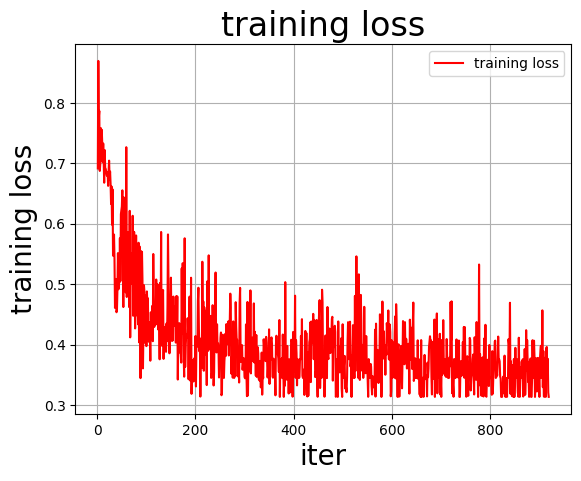

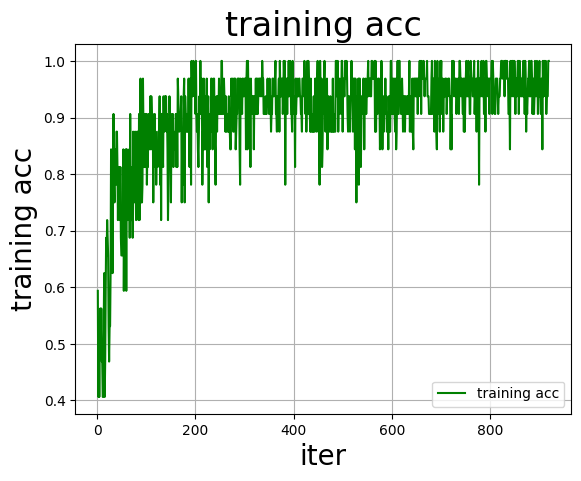

In [127]:
def train(model):
    model.train()
    opt = paddle.optimizer.Adam(learning_rate=0.002, parameters=model.parameters())

    steps = 0
    Iters, total_loss, total_acc = [], [], []

    for epoch in range(10):
        for batch_id, data in enumerate(train_loader):
            steps += 1
            sent = data[0]
            label = data[1]

            logits = model(sent)
            loss = paddle.nn.functional.cross_entropy(logits, label)
            acc = paddle.metric.accuracy(logits, label.reshape([-1, 1]))

            if batch_id % 50 == 0:
                print(f"epoch:{epoch}, batch_id:{batch_id}, loss:{float(loss.numpy()):.4f}, acc:{float(acc.numpy()):.4f}")


            # 记录训练过程
            Iters.append(steps)
            total_loss.append(float(loss.numpy()))
            total_acc.append(float(acc.numpy()))


            loss.backward()
            opt.step()
            opt.clear_grad()

        # 验证
        model.eval()
        accuracies = []
        losses = []

        with paddle.no_grad():
            for batch_id, data in enumerate(eval_loader):
                sent = data[0]
                label = data[1]

                logits = model(sent)
                loss = paddle.nn.functional.cross_entropy(logits, label)
                acc = paddle.metric.accuracy(logits, label.reshape([-1, 1]))

                accuracies.append(float(acc.numpy()))
                losses.append(float(loss.numpy()))


        avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
        print(f"[validation] accuracy: {avg_acc:.4f}, loss: {avg_loss:.4f}")
        model.train()

    paddle.save(model.state_dict(), "model_final.pdparams")

    draw_process("training loss", "red", Iters, total_loss, "training loss")
    draw_process("training acc", "green", Iters, total_acc, "training acc")
    
    
    
    
    
model=LstmModel()
train(model)
        

In [129]:
model_state_dict = paddle.load("model_final.pdparams")
model=LstmModel()
model.set_state_dict(model_state_dict)
model.eval()
accuracies= []
losses=[]
for batch_id,data in enumerate(eval_loader):
    sent=data[0]
    label=data[1]
    
    logits=model(sent)
    loss=paddle.nn.functional.cross_entropy(logits,label)
    acc=paddle.metric.accuracy(logits,label)
    
    accuracies.append(acc.numpy())
    losses.append(loss.numpy())
    
avg_acc,avg_loss=np.mean(accuracies),np.mean(losses)
print("eval_accuracy: %.5f, eval_loss: %.5f" % (avg_acc, avg_loss))

eval_accuracy: 0.83654, eval_loss: 0.46989


In [133]:
label_map = {0: '是', 1: '否'}

model.set_state_dict(model_state_dict)
model=LstmModel()
model.set_state_dict(model_state_dict)
model.eval()
for batch_id,data in enumerate(eval_loader()):
    sent=data[0]
    results=model(sent)
    
    predictions=[]
    for probs in results:
        idx=np.argmax(probs)
        labels=label_map[idx]
        predictions.append(labels)
        
    for i,pre in enumerate(predictions):
        print('数据:{} \n\n 是否谣言：{}'.format(ids_to_str(sent[0]),pre))
        break
    break
    
    

数据:【 紧 急 通 知 ！ 大 家 千 万 谨 慎 购 买 樱 桃 ！   】 今 年 樱 桃 里 寄 生 了 一 种 蛆 虫 ， 几 乎 大 部 分 的 樱 桃 里 面 都 有 。 实 验 方 法 ： 找 最 好 看 最 新 鲜 的 樱 桃 ， 放 透 明 玻 璃 杯 中 ， 倒 进 水 去 后 放 点 盐 ， 大 约 2 分 钟 就 会 看 到 这 些 蛆 虫 从 完 好 的 表 皮 往 外 钻 。 求 扩 散 ！ （ 转 ） 【 评 】 太 恶 心 了 ~ ~ 还 有 什 么 能 吃 的 ？ ！ 扩 散 ！ @ 李 小 朋 V   @ 摆 古 论 今 <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

 是否谣言：是
